In [1]:
import pandas as pd
from fbprophet import Prophet
from etl_resources import sqlite_connection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
def base_df():
    
    '''
    This function returns the base time series dataframe (date and close)
    '''
    
    con = sqlite_connection()
        
    df = pd.read_sql("select * from weekly_prices_clean where ticker='AMZN' and date>'2017-12-31' order by date desc",con=con)
    
    df[['ds', 'y']] = df[['date','close']]
    df = df[['ds', 'y']]
        
    return df

In [3]:
def train_test_split(df, split=0.2):
    
    test_rows = int(round(df.shape[0] * split,0))
    train_rows = df.shape[0] - test_rows
    
    test_df = df.head(test_rows).copy()
    train_df = df.tail(train_rows).copy()
    print(train_df.shape[0], test_df.shape[0])
    return train_df, test_df

317 79
Initial log joint probability = -3.64289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       917.553    0.00135082       184.392      0.7402      0.7402      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       931.334   0.000948762       359.268           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       935.197   0.000427754        107.52        2.91       0.291      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       935.693   2.95023e-05       99.5525      0.8104      0.8104      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       937.482   0.000233086       390.483    2.62e-07       0.001      571  LS failed, Hessian reset 
     499       940.361   0.000287

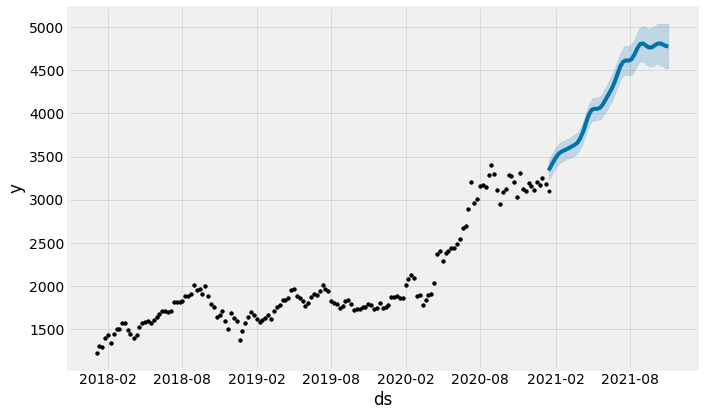

In [4]:
df = base_df()
train, test = train_test_split(df, split=0.2)
model = Prophet(daily_seasonality=True)
model.fit(train)
forecast = model.predict(test)
forecast.tail()

fig = model.plot(forecast)

In [5]:
print("Mean Squared Error (MSE):", mean_squared_error(y_true = test["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = test["y"], y_pred = forecast['yhat']))

def mean_abs_perc_err(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Absolute % Error (MAPE): ", mean_abs_perc_err(y_true = np.asarray(test["y"]), y_pred = np.asarray(forecast['yhat'])))

Mean Squared Error (MSE): 1077810.9800029253
Mean Absolute Error (MAE): 859.3090102279551
Mean Absolute % Error (MAPE):  26.524811170783323
